In [1]:
from transformers import EsmModel, AutoTokenizer
import torch
import torch.nn as nn
import numpy as np
import csv
from datasets import Dataset
import functools

DROPOUT = 0.25
OUTPUT_SIZE = 1
MAX_LENGTH = 1024
LABEL_PAD_TOKEN_ID = -100

# MODEL_NAME = "facebook/esm2_t6_8M_UR50D"
# MODEL_NAME = "facebook/esm2_t33_650M_UR50D"
MODEL_NAME = 'facebook/esm2_t36_3B_UR50D'

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

def print_used_memory():
    free, total = torch.cuda.mem_get_info(torch.device('cuda:0'))
    mem_used_MB = (total - free) / 1024 ** 2
    mem_total_MB = (total) / 1024 ** 2
    print(f'{mem_used_MB} MB / {mem_total_MB} MB')

class FinetuneESM(nn.Module):
    def __init__(self, esm_model: str) -> None:
        super().__init__()
        self.llm = EsmModel.from_pretrained(esm_model) #, torch_dtype=torch.bfloat16)
        self.dropout = nn.Dropout(DROPOUT)
        self.classifier = nn.Linear(self.llm.config.hidden_size, OUTPUT_SIZE) # , dtype=torch.bfloat16)
        
    def forward(self, batch: dict[str, np.ndarray]) -> torch.Tensor:
        input_ids, attention_mask = batch["input_ids"], batch["attention_mask"]
        token_embeddings = self.llm(
            input_ids=input_ids, attention_mask=attention_mask
        ).last_hidden_state

        return self.classifier(token_embeddings)

def get_dataset(annotation_path, tokenizer):

    sequences = []
    labels = []

    with open(annotation_path) as f:
        reader = csv.reader(f, delimiter=";")

        for row in reader:
            sequence = row[4]
            # max sequence length of ESM2
            if len(sequence) > MAX_LENGTH: continue 

            indices = [int(residue[1:]) for residue in row[3].split(' ')]
            label = np.zeros(len(sequence)) #, dtype=np.float16)
            label[indices] = 1
            sequences.append(sequence)
            labels.append(label) # np.eye(NUMBER_OF_CLASSES)[label])

            assert len(sequence) == len(label)

    tokenized_sequences = tokenizer(sequences, max_length=MAX_LENGTH, padding='max_length', truncation=True)

    dataset = Dataset.from_dict(tokenized_sequences)
    dataset = dataset.add_column("labels", labels)

    return dataset

def collate_fn(batch, tokenizer):

    if "distances" in batch[0].keys():
        label_names = ['labels', 'distances']
    else:
        label_names = ['labels']

    labels = {label_name: [feature[label_name] for feature in batch] for label_name in label_names}
    no_labels_features = [{k: v for k, v in feature.items() if k not in label_names} for feature in batch]

    batch = tokenizer.pad(
        no_labels_features,
        padding=True,
        max_length=MAX_LENGTH,
        return_tensors="pt").to(DEVICE)
    
    # type to bfloat16
    # batch['input_ids'] = batch['input_ids'].to(dtype=torch.float16).to(DEVICE)
    # batch['attention_mask'] = batch['attention_mask'].to(dtype=torch.float16).to(DEVICE)

    sequence_length = batch["input_ids"].shape[1]

    for label_name in label_names:
        batch[label_name] = [[LABEL_PAD_TOKEN_ID] + list(label) + [LABEL_PAD_TOKEN_ID] * (sequence_length - len(label)-1) for label in labels[label_name]]
        batch[label_name] = torch.tensor(batch[label_name]).to(DEVICE)# , dtype=torch.bfloat16).to(DEVICE)

    return batch

model = FinetuneESM(MODEL_NAME).half().to(DEVICE)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

from torch.utils.data import DataLoader

partial_collate_fn = functools.partial(collate_fn, tokenizer=tokenizer)

# train_dataset = get_dataset('/home/skrhakv/cryptic-nn/data/cryptobench/train.txt', tokenizer)
# val_dataset = get_dataset('/home/skrhakv/cryptic-nn/data/cryptobench/test.txt', tokenizer)
# 
# train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True, collate_fn=partial_collate_fn)
# val_dataloader = DataLoader(val_dataset, batch_size=val_dataset.num_rows, collate_fn=partial_collate_fn)
# 

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t36_3B_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


train end-to-end without lora

In [ ]:
from sklearn import metrics
import gc
import bitsandbytes as bnb

torch.manual_seed(42)
print_used_memory()

optimizer = bnb.optim.AdamW8bit(model.parameters(), lr=0.0001, eps=1e-4) 
# optimizer = torch.optim.AdamW8bit(params=model.parameters(),
#                             lr=0.0001)
EPOCHS = 10

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

class_weights = torch.tensor([0.5303, 8.7481], device='cuda:0')

# TODO: Try multiply the class_weights[1] * 2
# BCEWithLogitsLoss - sigmoid is already built-in!
loss_fn = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])

test_losses = []
train_losses = []

for epoch in range(EPOCHS):
    model.eval()
    # print('Before test:')
    # print_used_memory()
    # VALIDATION LOOP
    with torch.no_grad():
        for batch in val_dataloader:
            # input_ids = batch['input_ids'].to(DEVICE)
            # attention_mask = batch['attention_mask'].to(DEVICE)
            # print('before prediction:')
            # print_used_memory()

            output = model(batch)
            # print('after prediction:')
            # print_used_memory()
            logits = output.flatten(1)
            labels = batch['labels'].to(DEVICE)

            flattened_labels = labels.flatten()

            valid_flattened_logits = logits.flatten()[flattened_labels != -100]# .float()
            valid_flattened_labels = labels.flatten()[flattened_labels != -100]

            predictions = torch.round(torch.sigmoid(valid_flattened_logits))

            test_loss = loss_fn(valid_flattened_logits, valid_flattened_labels)

            test_losses.append(test_loss.cpu().float().detach().numpy())
            # print(valid_flattened_logits)
            # compute metrics on test dataset
            test_acc = accuracy_fn(y_true=valid_flattened_labels,
                                   y_pred=predictions)
            fpr, tpr, thresholds = metrics.roc_curve(valid_flattened_labels.cpu().float().numpy(), torch.sigmoid(valid_flattened_logits).cpu().float().numpy())
            roc_auc = metrics.auc(fpr, tpr)

            mcc = metrics.matthews_corrcoef(valid_flattened_labels.cpu().float().numpy(), predictions.cpu().float().numpy())
            del labels, logits, valid_flattened_logits, valid_flattened_labels, flattened_labels
            gc.collect()
            torch.cuda.empty_cache()
    
    # print('after test')
    # print_used_memory()

    model.train()

    batch_losses = []

    # TRAIN

    # TODO: the following row causes the memory explosion
    # with torch.inference_mode():

    for batch in train_dataloader:

        output = model(batch) #, attention_mask=attention_mask)
        logits = output.flatten(1)
        labels = batch['labels'].to(DEVICE)
        flattened_labels = labels.flatten()
        # print_used_memory()

        valid_flattened_logits = logits.flatten()[flattened_labels != -100]
        valid_flattened_labels = labels.flatten()[flattened_labels != -100]

        loss = loss_fn(valid_flattened_logits, valid_flattened_labels)
        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        batch_losses.append(loss.cpu().float().detach().numpy())
        
        del labels, logits, valid_flattened_logits, valid_flattened_labels, flattened_labels
        gc.collect()
        torch.cuda.empty_cache()

    train_losses.append(sum(batch_losses) / len(batch_losses))
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {test_acc:.2f}% | Test loss: {test_loss:.5f}, AUC: {roc_auc}, MCC: {mcc}, sum: {sum(predictions)}")

# 850M without LORA - here:
# Epoch: 1 | Loss: 0.26357, Accuracy: 88.84% | Test loss: 0.59217, AUC: 0.8772442293540929, MCC: 0.3847349478773821, sum: 7178.0
# 
# 850M without LORA - custom-finetuning.ipynb:
# Epoch: 1 | Loss: 0.34253, Accuracy: 91.27% | Test loss: 0.59555, AUC: 0.878478909678348, MCC: 0.41902639123765595, sum: 5562.0



6097.0625 MB / 81090.125 MB


/home/skrhakv/cryptic-nn/src/fine-tuning/esmc-venv/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2699: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/home/skrhakv/cryptic-nn/src/fine-tuning/esmc-venv/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2699: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Epoch: 0 | Loss: 0.93886, Accuracy: 75.37% | Test loss: 0.98541, AUC: 0.4966444777008342, MCC: 0.00851241159477756, sum: 2048.0


/home/skrhakv/cryptic-nn/src/fine-tuning/esmc-venv/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2699: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Epoch: 1 | Loss: 0.41030, Accuracy: 86.53% | Test loss: 0.58455, AUC: 0.8831857513908667, MCC: 0.38747096053283003, sum: 2048.0


/home/skrhakv/cryptic-nn/src/fine-tuning/esmc-venv/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2699: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Epoch: 2 | Loss: 0.16598, Accuracy: 89.82% | Test loss: 0.56725, AUC: 0.8894166977418276, MCC: 0.4210427297022199, sum: 2048.0


/home/skrhakv/cryptic-nn/src/fine-tuning/esmc-venv/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2699: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Epoch: 3 | Loss: 1.01018, Accuracy: 91.55% | Test loss: 0.68505, AUC: 0.8826773671146894, MCC: 0.424533219608909, sum: 2048.0


/home/skrhakv/cryptic-nn/src/fine-tuning/esmc-venv/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2699: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Epoch: 4 | Loss: 0.93870, Accuracy: 94.32% | Test loss: 0.94482, AUC: 0.5987813101629393, MCC: 0.0, sum: 0.0


/home/skrhakv/cryptic-nn/src/fine-tuning/esmc-venv/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2699: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x1524b8ac7950>>
Traceback (most recent call last):
  File "/home/skrhakv/cryptic-nn/src/fine-tuning/esmc-venv/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


KeyboardInterrupt: 

LORA

In [ ]:
import sys
sys.path.append('/home/skrhakv/cryptic-nn/src/fine-tuning')

from lora import apply_lora # , freeze_all_but_head

apply_lora(model) # .to(DEVICE)

from sklearn import metrics
import gc

torch.manual_seed(42)
print_used_memory()
optimizer = torch.optim.AdamW(params=model.parameters(),
                            lr=0.0001)
EPOCHS = 10

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

class_weights = torch.tensor([0.5303, 8.7481], device='cuda:0')

# TODO: Try multiply the class_weights[1] * 2
# BCEWithLogitsLoss - sigmoid is already built-in!
loss_fn = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])

test_losses = []
train_losses = []

for epoch in range(EPOCHS):
    model.eval()
    # print('Before test:')
    # print_used_memory()
    # VALIDATION LOOP
    with torch.no_grad():
        for batch in val_dataloader:
            # input_ids = batch['input_ids'].to(DEVICE)
            # attention_mask = batch['attention_mask'].to(DEVICE)
            # print('before prediction:')
            # print_used_memory()

            output = model(batch)
            # print('after prediction:')
            # print_used_memory()
            logits = output.flatten(1)
            labels = batch['labels'].to(DEVICE)

            flattened_labels = labels.flatten()

            valid_flattened_logits = logits.flatten()[flattened_labels != -100]# .float()
            valid_flattened_labels = labels.flatten()[flattened_labels != -100]

            predictions = torch.round(torch.sigmoid(valid_flattened_logits))

            test_loss = loss_fn(valid_flattened_logits, valid_flattened_labels)

            test_losses.append(test_loss.cpu().float().detach().numpy())
            # print(valid_flattened_logits)
            # compute metrics on test dataset
            test_acc = accuracy_fn(y_true=valid_flattened_labels,
                                   y_pred=predictions)
            fpr, tpr, thresholds = metrics.roc_curve(valid_flattened_labels.cpu().float().numpy(), torch.sigmoid(valid_flattened_logits).cpu().float().numpy())
            roc_auc = metrics.auc(fpr, tpr)

            mcc = metrics.matthews_corrcoef(valid_flattened_labels.cpu().float().numpy(), predictions.cpu().float().numpy())
            del labels, logits, valid_flattened_logits, valid_flattened_labels, flattened_labels
            gc.collect()
            torch.cuda.empty_cache()
    
    # print('after test')
    # print_used_memory()

    model.train()

    batch_losses = []

    # TRAIN

    # TODO: the following row causes the memory explosion
    # with torch.inference_mode():

    for batch in train_dataloader:

        output = model(batch) #, attention_mask=attention_mask)
        logits = output.flatten(1)
        labels = batch['labels'].to(DEVICE)
        flattened_labels = labels.flatten()
        # print_used_memory()

        valid_flattened_logits = logits.flatten()[flattened_labels != -100]
        valid_flattened_labels = labels.flatten()[flattened_labels != -100]

        loss = loss_fn(valid_flattened_logits, valid_flattened_labels)
        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        batch_losses.append(loss.cpu().float().detach().numpy())
        
        del labels, logits, valid_flattened_logits, valid_flattened_labels, flattened_labels
        gc.collect()
        torch.cuda.empty_cache()

    train_losses.append(sum(batch_losses) / len(batch_losses))
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {test_acc:.2f}% | Test loss: {test_loss:.5f}, AUC: {roc_auc}, MCC: {mcc}, sum: {sum(predictions)}")

# 850M without LORA - here:
# Epoch: 1 | Loss: 0.26357, Accuracy: 88.84% | Test loss: 0.59217, AUC: 0.8772442293540929, MCC: 0.3847349478773821, sum: 7178.0
# 
# 850M with LORA - here:
# Epoch: 3 | Loss: 0.93123, Accuracy: 86.97% | Test loss: 0.63380, AUC: 0.8560885121193611, MCC: 0.3594092927832279, sum: 8330.0
#
# 850M without LORA - custom-finetuning.ipynb:
# Epoch: 1 | Loss: 0.34253, Accuracy: 91.27% | Test loss: 0.59555, AUC: 0.878478909678348, MCC: 0.41902639123765595, sum: 5562.0



3081.0625 MB / 81090.125 MB


/home/skrhakv/deeplife/venv/lib64/python3.9/site-packages/transformers/tokenization_utils_base.py:2706: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/home/skrhakv/deeplife/venv/lib64/python3.9/site-packages/transformers/tokenization_utils_base.py:2706: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Epoch: 0 | Loss: 1.07641, Accuracy: 84.94% | Test loss: 0.96781, AUC: 0.5584380776297676, MCC: 0.06338426312302034, sum: 6467.0


/home/skrhakv/deeplife/venv/lib64/python3.9/site-packages/transformers/tokenization_utils_base.py:2706: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Epoch: 1 | Loss: 0.98292, Accuracy: 90.08% | Test loss: 0.70329, AUC: 0.828017489151323, MCC: 0.33694228067099186, sum: 5599.0


/home/skrhakv/deeplife/venv/lib64/python3.9/site-packages/transformers/tokenization_utils_base.py:2706: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Epoch: 2 | Loss: 0.28898, Accuracy: 94.32% | Test loss: 0.92707, AUC: 0.5952360896233821, MCC: 0.0, sum: 0.0


/home/skrhakv/deeplife/venv/lib64/python3.9/site-packages/transformers/tokenization_utils_base.py:2706: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Epoch: 3 | Loss: 0.93123, Accuracy: 86.97% | Test loss: 0.63380, AUC: 0.8560885121193611, MCC: 0.3594092927832279, sum: 8330.0


/home/skrhakv/deeplife/venv/lib64/python3.9/site-packages/transformers/tokenization_utils_base.py:2706: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Epoch: 4 | Loss: 0.35971, Accuracy: 86.21% | Test loss: 0.64358, AUC: 0.8543168563973295, MCC: 0.3511116215049817, sum: 8806.0


/home/skrhakv/deeplife/venv/lib64/python3.9/site-packages/transformers/tokenization_utils_base.py:2706: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Epoch: 5 | Loss: 0.20516, Accuracy: 89.37% | Test loss: 0.70072, AUC: 0.8532096263216228, MCC: 0.3716428972575048, sum: 6588.0


/home/skrhakv/deeplife/venv/lib64/python3.9/site-packages/transformers/tokenization_utils_base.py:2706: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
from transformers import AutoModelForTokenClassification
model = AutoModelForTokenClassification.from_pretrained('Synthyra/ESMplusplus_large', num_labels=1, problem_type='single_label_classification').to(DEVICE)
tokenizer = model.tokenizer


Some weights of ESMplusplusForTokenClassification were not initialized from the model checkpoint at Synthyra/ESMplusplus_large and are newly initialized: ['classifier.0.bias', 'classifier.0.weight', 'classifier.2.bias', 'classifier.2.weight', 'classifier.3.bias', 'classifier.3.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


esm++ tryout ..

In [8]:

from torch.utils.data import DataLoader

partial_collate_fn = functools.partial(collate_fn, tokenizer=tokenizer)

train_dataset = get_dataset('/home/skrhakv/cryptic-nn/data/cryptobench/train.txt', tokenizer)
val_dataset = get_dataset('/home/skrhakv/cryptic-nn/data/cryptobench/test.txt', tokenizer)

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=partial_collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=val_dataset.num_rows, collate_fn=partial_collate_fn)


from sklearn import metrics
import gc

torch.manual_seed(42)
print_used_memory()
optimizer = torch.optim.AdamW(params=model.parameters(),
                            lr=0.0001)
EPOCHS = 10

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

class_weights = torch.tensor([0.5303, 8.7481], device='cuda:0')

# TODO: Try multiply the class_weights[1] * 2
# BCEWithLogitsLoss - sigmoid is already built-in!
loss_fn = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])

test_losses = []
train_losses = []

for epoch in range(EPOCHS):
    model.eval()
    # print('Before test:')
    # print_used_memory()
    # VALIDATION LOOP
    with torch.no_grad():
        for batch in val_dataloader:
            input_ids = batch['input_ids'].to(DEVICE)
            attention_mask = batch['attention_mask'].to(DEVICE)
            # print('before prediction:')
            # print_used_memory()

            output = model(input_ids, attention_mask=attention_mask)
            # print('after prediction:')
            # print_used_memory()
            # print(output)
            logits = output.logits.flatten(1)
            labels = batch['labels'].to(DEVICE)

            flattened_labels = labels.flatten()

            # print(output.logits.shape, flattened_labels.shape)
            valid_flattened_logits = logits.flatten()[flattened_labels != -100]# .float()
            valid_flattened_labels = labels.flatten()[flattened_labels != -100]

            predictions = torch.round(torch.sigmoid(valid_flattened_logits))

            test_loss = loss_fn(valid_flattened_logits, valid_flattened_labels)

            test_losses.append(test_loss.cpu().float().detach().numpy())
            # print(valid_flattened_logits)
            # compute metrics on test dataset
            test_acc = accuracy_fn(y_true=valid_flattened_labels,
                                   y_pred=predictions)
            fpr, tpr, thresholds = metrics.roc_curve(valid_flattened_labels.cpu().float().numpy(), torch.sigmoid(valid_flattened_logits).cpu().float().numpy())
            roc_auc = metrics.auc(fpr, tpr)

            mcc = metrics.matthews_corrcoef(valid_flattened_labels.cpu().float().numpy(), predictions.cpu().float().numpy())
            del labels, logits, valid_flattened_logits, valid_flattened_labels, flattened_labels
            gc.collect()
            torch.cuda.empty_cache()
    
    # print('after test')
    # print_used_memory()

    model.train()

    batch_losses = []

    # TRAIN

    # TODO: the following row causes the memory explosion
    # with torch.inference_mode():

    for batch in train_dataloader:
        input_ids = batch['input_ids'].to(DEVICE)
        attention_mask = batch['attention_mask'].to(DEVICE)

        output = model(input_ids, attention_mask=attention_mask) #, attention_mask=attention_mask)
        logits = output.logits.flatten(1)
        labels = batch['labels'].to(DEVICE)
        flattened_labels = labels.flatten()
        # print_used_memory()

        valid_flattened_logits = logits.flatten()[flattened_labels != -100]
        valid_flattened_labels = labels.flatten()[flattened_labels != -100]

        loss = loss_fn(valid_flattened_logits, valid_flattened_labels)
        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        batch_losses.append(loss.cpu().float().detach().numpy())
        
        del labels, logits, valid_flattened_logits, valid_flattened_labels, flattened_labels
        gc.collect()
        torch.cuda.empty_cache()

    train_losses.append(sum(batch_losses) / len(batch_losses))
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {test_acc:.2f}% | Test loss: {test_loss:.5f}, AUC: {roc_auc}, MCC: {mcc}, sum: {sum(predictions)}")

# 850M without LORA - here:
# Epoch: 1 | Loss: 0.26357, Accuracy: 88.84% | Test loss: 0.59217, AUC: 0.8772442293540929, MCC: 0.3847349478773821, sum: 7178.0
# 
# 850M with LORA - here:
# Epoch: 3 | Loss: 0.93123, Accuracy: 86.97% | Test loss: 0.63380, AUC: 0.8560885121193611, MCC: 0.3594092927832279, sum: 8330.0
#
# 850M without LORA - custom-finetuning.ipynb:
# Epoch: 1 | Loss: 0.34253, Accuracy: 91.27% | Test loss: 0.59555, AUC: 0.878478909678348, MCC: 0.41902639123765595, sum: 5562.0



18529.0625 MB / 81090.125 MB
torch.Size([184, 1024, 1]) torch.Size([188416])
tensor([0.1934], device='cuda:0')


/home/skrhakv/cryptic-nn/src/fine-tuning/venv_esmplusplus/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2718: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Epoch: 0 | Loss: 0.80839, Accuracy: 19.61% | Test loss: 1.76119, AUC: 0.4258982469501052, MCC: -0.07413211318761029, sum: 46029.0
torch.Size([184, 1024, 1]) torch.Size([188416])
tensor([0.0760], device='cuda:0')


/home/skrhakv/cryptic-nn/src/fine-tuning/venv_esmplusplus/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2718: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Epoch: 1 | Loss: 0.38677, Accuracy: 82.28% | Test loss: 0.62088, AUC: 0.8778704881941413, MCC: 0.3450996010979654, sum: 11621.0
torch.Size([184, 1024, 1]) torch.Size([188416])
tensor([-0.1264], device='cuda:0')


/home/skrhakv/cryptic-nn/src/fine-tuning/venv_esmplusplus/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2718: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Epoch: 2 | Loss: 0.09270, Accuracy: 88.66% | Test loss: 0.66985, AUC: 0.8738272595540745, MCC: 0.3814881770277971, sum: 7282.0
torch.Size([184, 1024, 1]) torch.Size([188416])
tensor([-0.7474], device='cuda:0')


/home/skrhakv/cryptic-nn/src/fine-tuning/venv_esmplusplus/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2718: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Epoch: 3 | Loss: 0.19809, Accuracy: 92.79% | Test loss: 0.98229, AUC: 0.8650654748465431, MCC: 0.4265198775537588, sum: 4246.0
torch.Size([184, 1024, 1]) torch.Size([188416])
tensor([-1.1127], device='cuda:0')


/home/skrhakv/cryptic-nn/src/fine-tuning/venv_esmplusplus/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2718: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Epoch: 4 | Loss: 0.03363, Accuracy: 90.89% | Test loss: 1.24782, AUC: 0.8564089380902804, MCC: 0.38666894885946734, sum: 5505.0
torch.Size([184, 1024, 1]) torch.Size([188416])
tensor([-0.6319], device='cuda:0')


/home/skrhakv/cryptic-nn/src/fine-tuning/venv_esmplusplus/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2718: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Epoch: 5 | Loss: 0.04672, Accuracy: 91.43% | Test loss: 1.16187, AUC: 0.8604517740366541, MCC: 0.4091554389917905, sum: 5298.0
torch.Size([184, 1024, 1]) torch.Size([188416])
tensor([-0.9140], device='cuda:0')


/home/skrhakv/cryptic-nn/src/fine-tuning/venv_esmplusplus/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2718: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Epoch: 6 | Loss: 0.05581, Accuracy: 92.45% | Test loss: 1.34929, AUC: 0.8511572368989107, MCC: 0.39652730919182694, sum: 4219.0
torch.Size([184, 1024, 1]) torch.Size([188416])
tensor([-1.0599], device='cuda:0')


/home/skrhakv/cryptic-nn/src/fine-tuning/venv_esmplusplus/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2718: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Epoch: 7 | Loss: 0.00296, Accuracy: 92.82% | Test loss: 1.95489, AUC: 0.8424755979534786, MCC: 0.3872959655490615, sum: 3764.0
torch.Size([184, 1024, 1]) torch.Size([188416])
tensor([-1.2158], device='cuda:0')


/home/skrhakv/cryptic-nn/src/fine-tuning/venv_esmplusplus/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2718: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Epoch: 8 | Loss: 0.06317, Accuracy: 92.07% | Test loss: 1.72772, AUC: 0.8482709805426195, MCC: 0.3931933804662767, sum: 4532.0
torch.Size([184, 1024, 1]) torch.Size([188416])
tensor([-1.6969], device='cuda:0')


/home/skrhakv/cryptic-nn/src/fine-tuning/venv_esmplusplus/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2718: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Epoch: 9 | Loss: 0.00201, Accuracy: 92.85% | Test loss: 2.02877, AUC: 0.8289615701010321, MCC: 0.36783836976154755, sum: 3526.0


In [10]:
from datasets import Dataset
import csv
import numpy as np

MAX_LENGTH = 1024

def get_dataset_with_distances(annotation_path, tokenizer, scaler, distances_path='/home/skrhakv/cryptic-nn/data/cryptobench/residue-distances', uniprot_ids=False):

    sequences = []
    labels = []
    distances = []
    with open(annotation_path) as f:
        reader = csv.reader(f, delimiter=";")

        for row in reader:
            if not uniprot_ids:
                protein_id = row[0].lower() + row[1]
            else:
                protein_id = row[0]
            sequence = row[4]
            # max sequence length of ESM2
            if len(sequence) > MAX_LENGTH: continue 
            
            indices = [int(residue[1:]) for residue in row[3].split(' ')]
            label = np.zeros(len(sequence))
            label[indices] = 1
            distance = np.load(f'{distances_path}/{protein_id}.npy')
            distance[distance == -1] = 0.5
            distance = np.clip(distance, 0, 10)

            if len(distance) != len(sequence): 
                print(f'{protein_id} doesn\'t match. Skipping ...')
                break

            # scale the distance
            distance = scaler.transform(distance.reshape(-1, 1)).reshape(1, -1)[0]

            sequences.append(sequence)
            labels.append(label) # np.eye(NUMBER_OF_CLASSES)[label])
            distances.append(distance)
    train_tokenized = tokenizer(sequences) #, padding='max_length', truncation=True, max_length=MAX_LENGTH)# , max_length=MAX_LENGTH, padding=True, truncation=True)
    
    dataset = Dataset.from_dict(train_tokenized)
    dataset = dataset.add_column("labels", labels)
    dataset = dataset.add_column("distances", distances)
    
    return dataset

from sklearn.preprocessing import StandardScaler, MinMaxScaler

def train_scaler(annotation_path, distances_path='/home/skrhakv/cryptic-nn/data/cryptobench/residue-distances', uniprot_ids=False):
    distances = []

    with open(annotation_path) as f:
        reader = csv.reader(f, delimiter=";")

        for row in reader:
            if not uniprot_ids:
                protein_id = row[0].lower() + row[1]
            else:
                protein_id = row[0]
            distance = np.load(f'{distances_path}/{protein_id}.npy')
            distance[distance == -1] = 0.5
            distances.append(distance)

    scaler = MinMaxScaler()
    scaler.fit(np.concatenate(distances).reshape(-1, 1))
    return scaler


In [38]:
from transformers import AutoModelForTokenClassification
model = AutoModelForTokenClassification.from_pretrained('Synthyra/ESMplusplus_large', num_labels=3).to(DEVICE)
tokenizer = model.tokenizer

# train only the classifier for the first few epochs 
for name, param in model.named_parameters():
     if name.startswith('transformer'): # choose whatever you like here
        param.requires_grad = False

scaler = train_scaler('/home/skrhakv/cryptic-nn/data/ligysis/train.txt', distances_path='/home/skrhakv/cryptic-nn/data/ligysis/plDDT', uniprot_ids=True)
train_dataset = get_dataset_with_distances('/home/skrhakv/cryptic-nn/data/ligysis/train.txt', tokenizer, scaler, distances_path='/home/skrhakv/cryptic-nn/data/ligysis/plDDT', uniprot_ids=True)
val_dataset = get_dataset_with_distances('/home/skrhakv/cryptic-nn/data/cryptobench/test.txt', tokenizer, scaler)

from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=partial_collate_fn) 
val_dataloader = DataLoader(val_dataset, batch_size=val_dataset.num_rows, collate_fn=partial_collate_fn)

torch.manual_seed(42)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model.to(device)
optimizer = torch.optim.AdamW(params=model.parameters(),
                            lr=0.0001)
EPOCHS = 4

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

class_weights = torch.tensor([0.5303, 8.7481], device='cuda:0')

# TODO: Try multiply the class_weights[1] * 2
# BCEWithLogitsLoss - sigmoid is already built-in!
cbs_loss_fn = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])
plDDT_loss_fn = nn.MSELoss() 

test_losses = []
train_losses = []

for epoch in range(EPOCHS):
    # unfreeze and do end-to-end finetuning after training only the classifier for the first few epochs 
    if epoch > 1:
        for name, param in model.named_parameters():
            param.requires_grad = True

    model.eval()
    
    # VALIDATION LOOP
    with torch.inference_mode():
        for batch in val_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            output = model(input_ids, attention_mask=attention_mask)
            
            cbs_logits = output.logits[:,:,0]
            distance_logits = output.logits[:,:,1]
            
            labels = batch['labels'].to(device)
            distances = batch['distances'].to(device)

            flattened_labels = labels.flatten()

            valid_flattened_cbs_logits = cbs_logits.flatten()[flattened_labels != -100]
            valid_flattened_distance_logits = distance_logits.flatten()[flattened_labels != -100]
            valid_flattened_labels = labels.flatten()[flattened_labels != -100]
            valid_flattened_distances = distances.flatten()[flattened_labels != -100]

            predictions = torch.round(torch.sigmoid(valid_flattened_cbs_logits))

            cbs_test_loss =  cbs_loss_fn(valid_flattened_cbs_logits, valid_flattened_labels)
            # distances_test_loss =  distances_loss_fn(torch.sigmoid(valid_flattened_distance_logits), valid_flattened_distances)

            test_loss = cbs_test_loss # + distances_test_loss
            test_losses.append(test_loss.cpu().detach().numpy())

            # compute metrics on test dataset
            test_acc = accuracy_fn(y_true=valid_flattened_labels,
                                   y_pred=predictions)

            # print(torch.sum(torch.isnan(torch.sigmoid(valid_flattened_cbs_logits))))
            fpr, tpr, thresholds = metrics.roc_curve(valid_flattened_labels.cpu().numpy(), torch.sigmoid(valid_flattened_cbs_logits).cpu().numpy())
            roc_auc = metrics.auc(fpr, tpr)

            mcc = metrics.matthews_corrcoef(valid_flattened_labels.cpu().numpy(), predictions.cpu().numpy())
    
    torch.cuda.empty_cache()

    model.train()

    batch_losses = []

    # TRAIN
    for batch in train_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        # Padded labels from the data collator
        # padded_labels += batch['labels'].tolist()

        output = model(input_ids, attention_mask=attention_mask)
        
        cbs_logits = output.logits[:,:,0]
        distance_logits = output.logits[:,:,1]

        labels = batch['labels'].to(device)
        distances = batch['distances'].to(device)

        flattened_labels = labels.flatten()

        valid_flattened_cbs_logits = cbs_logits.flatten()[flattened_labels != -100]
        valid_flattened_distance_logits = distance_logits.flatten()[flattened_labels != -100]
        valid_flattened_labels = labels.flatten()[flattened_labels != -100]
        valid_flattened_distances = distances.flatten()[flattened_labels != -100]

        cbs_loss =  cbs_loss_fn(valid_flattened_cbs_logits, valid_flattened_labels)
        distances_loss =  plDDT_loss_fn(torch.sigmoid(valid_flattened_distance_logits), valid_flattened_distances)
        
        # different loss, sigmoid
        loss = cbs_loss +  distances_loss
        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        batch_losses.append(loss.cpu().detach().numpy())
        
    torch.cuda.empty_cache()

    train_losses.append(sum(batch_losses) / len(batch_losses))
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {test_acc:.2f}% | Test loss: {test_loss:.5f} - CBS: {cbs_test_loss:.5f}, AUC: {roc_auc:.7f}, MCC: {mcc:.5f}, sum: {sum(predictions)}")

Some weights of ESMplusplusForTokenClassification were not initialized from the model checkpoint at Synthyra/ESMplusplus_large and are newly initialized: ['classifier.0.bias', 'classifier.0.weight', 'classifier.2.bias', 'classifier.2.weight', 'classifier.3.bias', 'classifier.3.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/skrhakv/cryptic-nn/src/fine-tuning/venv_esmplusplus/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2718: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/home/skrhakv/cryptic-nn/src/fine-tuning/venv_esmplusplus/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2718: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Epoch: 0 | Loss: 0.89152, Accuracy: 54.79% | Test loss: 1.08529 - CBS: 1.08529, AUC: 0.6218540, MCC: 0.08392, sum: 25996.0


/home/skrhakv/cryptic-nn/src/fine-tuning/venv_esmplusplus/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2718: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Epoch: 1 | Loss: 0.53873, Accuracy: 83.67% | Test loss: 0.71629 - CBS: 0.71629, AUC: 0.8344590, MCC: 0.30053, sum: 10030.0


/home/skrhakv/cryptic-nn/src/fine-tuning/venv_esmplusplus/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2718: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Epoch: 2 | Loss: 0.63747, Accuracy: 75.40% | Test loss: 0.76744 - CBS: 0.76744, AUC: 0.8411284, MCC: 0.27558, sum: 15445.0


/home/skrhakv/cryptic-nn/src/fine-tuning/venv_esmplusplus/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2718: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
scaler = train_scaler('/home/skrhakv/cryptic-nn/data/cryptobench/train.txt')
train_dataset = get_dataset_with_distances('/home/skrhakv/cryptic-nn/data/cryptobench/train.txt', tokenizer, scaler)
val_dataset = get_dataset_with_distances('/home/skrhakv/cryptic-nn/data/cryptobench/test.txt', tokenizer, scaler)

from torch.utils.data import DataLoader

# similarly train only the classifier for the first few epochs 
# for name, param in model.named_parameters():
#      if name.startswith('transformer'): # choose whatever you like here
#         param.requires_grad = False

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=partial_collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=val_dataset.num_rows, collate_fn=partial_collate_fn)

torch.manual_seed(42)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

EPOCHS = 8

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

class_weights = torch.tensor([0.5303, 8.7481], device='cuda:0')

# TODO: Try multiply the class_weights[1] * 2
# BCEWithLogitsLoss - sigmoid is already built-in!
cbs_loss_fn = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])
plDDT_loss_fn = nn.MSELoss() 

test_losses = []
train_losses = []

for epoch in range(EPOCHS):
    # unfreeze and do end-to-end finetuning after training only the classifier for the first few epochs 
    if epoch > 1:
        for name, param in model.named_parameters():
            param.requires_grad = True

    model.eval()
    
    # VALIDATION LOOP
    with torch.inference_mode():
        for batch in val_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            output = model(input_ids, attention_mask=attention_mask)
            
            cbs_logits = output.logits[:,:,0]
            distance_logits = output.logits[:,:,2]
            
            labels = batch['labels'].to(device)
            distances = batch['distances'].to(device)

            flattened_labels = labels.flatten()

            valid_flattened_cbs_logits = cbs_logits.flatten()[flattened_labels != -100]
            valid_flattened_distance_logits = distance_logits.flatten()[flattened_labels != -100]
            valid_flattened_labels = labels.flatten()[flattened_labels != -100]
            valid_flattened_distances = distances.flatten()[flattened_labels != -100]

            predictions = torch.round(torch.sigmoid(valid_flattened_cbs_logits))

            cbs_test_loss =  cbs_loss_fn(valid_flattened_cbs_logits, valid_flattened_labels)
            # distances_test_loss =  distances_loss_fn(torch.sigmoid(valid_flattened_distance_logits), valid_flattened_distances)

            test_loss = cbs_test_loss # + distances_test_loss
            test_losses.append(test_loss.cpu().detach().numpy())

            # compute metrics on test dataset
            test_acc = accuracy_fn(y_true=valid_flattened_labels,
                                   y_pred=predictions)

            # print(torch.sum(torch.isnan(torch.sigmoid(valid_flattened_cbs_logits))))
            fpr, tpr, thresholds = metrics.roc_curve(valid_flattened_labels.cpu().numpy(), torch.sigmoid(valid_flattened_cbs_logits).cpu().numpy())
            roc_auc = metrics.auc(fpr, tpr)

            mcc = metrics.matthews_corrcoef(valid_flattened_labels.cpu().numpy(), predictions.cpu().numpy())
    
    torch.cuda.empty_cache()

    model.train()

    batch_losses = []

    # TRAIN
    for batch in train_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        # Padded labels from the data collator
        # padded_labels += batch['labels'].tolist()

        output = model(input_ids, attention_mask=attention_mask)
        
        cbs_logits = output.logits[:,:,0]
        distance_logits = output.logits[:,:,2]

        labels = batch['labels'].to(device)
        distances = batch['distances'].to(device)

        flattened_labels = labels.flatten()

        valid_flattened_cbs_logits = cbs_logits.flatten()[flattened_labels != -100]
        valid_flattened_distance_logits = distance_logits.flatten()[flattened_labels != -100]
        valid_flattened_labels = labels.flatten()[flattened_labels != -100]
        valid_flattened_distances = distances.flatten()[flattened_labels != -100]

        cbs_loss =  cbs_loss_fn(valid_flattened_cbs_logits, valid_flattened_labels)
        distances_loss =  plDDT_loss_fn(torch.sigmoid(valid_flattened_distance_logits), valid_flattened_distances.float())
        
        # different loss, sigmoid
        loss = cbs_loss +  distances_loss
        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        batch_losses.append(loss.cpu().detach().numpy())
        
    torch.cuda.empty_cache()

    train_losses.append(sum(batch_losses) / len(batch_losses))
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {test_acc:.2f}% | Test loss: {test_loss:.5f} - CBS: {cbs_test_loss:.5f}, AUC: {roc_auc:.7f}, MCC: {mcc:.5f}, sum: {sum(predictions)}")

# ligysis - freezing first 3 epochs, then 3 epochs full; CryptoBench - freezing first 3 epochs, then full:
# Epoch: 3 | Loss: 0.51589, Accuracy: 89.64% | Test loss: 0.57979 - CBS: 0.57979, AUC: 0.8856013, MCC: 0.42233, sum: 7002.0


/home/skrhakv/cryptic-nn/src/fine-tuning/venv_esmplusplus/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2718: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/home/skrhakv/cryptic-nn/src/fine-tuning/venv_esmplusplus/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2718: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Epoch: 0 | Loss: 0.45650, Accuracy: 90.52% | Test loss: 0.81983 - CBS: 0.81983, AUC: 0.8717390, MCC: 0.42576, sum: 6302.0


/home/skrhakv/cryptic-nn/src/fine-tuning/venv_esmplusplus/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2718: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Epoch: 1 | Loss: 0.11850, Accuracy: 89.87% | Test loss: 0.94013 - CBS: 0.94013, AUC: 0.8638283, MCC: 0.40362, sum: 6570.0


/home/skrhakv/cryptic-nn/src/fine-tuning/venv_esmplusplus/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2718: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


KeyboardInterrupt: 

emsC tryout ...

In [ ]:
from esm.models.esmc import ESMC

def get_dataset(annotation_path, tokenizer):

    sequences = []
    labels = []

    with open(annotation_path) as f:
        reader = csv.reader(f, delimiter=";")

        for row in reader:
            sequence = row[4]
            # max sequence length of ESM2
            if len(sequence) > MAX_LENGTH: continue 

            indices = [int(residue[1:]) for residue in row[3].split(' ')]
            label = np.zeros(len(sequence)) #, dtype=np.float16)
            label[indices] = 1
            sequences.append(sequence)
            labels.append(label) # np.eye(NUMBER_OF_CLASSES)[label])

            assert len(sequence) == len(label)

    tokenized_sequences = tokenizer(sequences, max_length=MAX_LENGTH, padding='max_length', truncation=True)

    dataset = Dataset.from_dict(tokenized_sequences)
    dataset = dataset.add_column("labels", labels)

    return dataset


ESMC_DIM = 1152
OUTPUT_SIZE = 1

class EsmForTokenClassificationCustom(nn.Module):
    def __init__(self):
        super().__init__()

        self.esm = ESMC.from_pretrained("esmc_600m")
        self.dropout = nn.Dropout(DROPOUT)
        self.classifier = nn.Linear(ESMC_DIM, OUTPUT_SIZE)
        self.tokenizer = self.esm.tokenizer

    def forward(self, input, sequence_id):
        outputs = self.esm(input, sequence_id).embeddings.float()
        outputs = self.dropout(outputs)
        outputs = self.classifier(outputs)
        return outputs



In [ ]:
from transformers import AutoModelForTokenClassification

model = AutoModelForTokenClassification.from_pretrained('Synthyra/ESMplusplus_large', num_labels=3).to(DEVICE)
tokenizer = model.tokenizer
model = EsmForTokenClassificationCustom()


train_dataset = get_dataset('/home/skrhakv/cryptic-nn/data/cryptobench/train.txt', model.tokenizer)
val_dataset = get_dataset('/home/skrhakv/cryptic-nn/data/cryptobench/test.txt', model.tokenizer)

partial_collate_fn = functools.partial(collate_fn, tokenizer=tokenizer)

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=partial_collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=val_dataset.num_rows, collate_fn=partial_collate_fn)


Some weights of ESMplusplusForTokenClassification were not initialized from the model checkpoint at Synthyra/ESMplusplus_large and are newly initialized: ['classifier.0.bias', 'classifier.0.weight', 'classifier.2.bias', 'classifier.2.weight', 'classifier.3.bias', 'classifier.3.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
model = EsmForTokenClassificationCustom().to(DEVICE)

from torch.utils.data import DataLoader

from sklearn import metrics
import gc

torch.manual_seed(42)
print_used_memory()
optimizer = torch.optim.AdamW(params=model.parameters(),
                            lr=0.0001)
EPOCHS = 12

for name, param in model.named_parameters():
     if name.startswith('esm'): # choose whatever you like here
        param.requires_grad = False

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

class_weights = torch.tensor([0.5303, 8.7481], device='cuda:0')

# TODO: Try multiply the class_weights[1] * 2
# BCEWithLogitsLoss - sigmoid is already built-in!
loss_fn = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])

test_losses = []
train_losses = []

for epoch in range(EPOCHS):
    model.eval()

    if epoch > 2:
        for name, param in model.named_parameters():
            param.requires_grad = True

    # print('Before test:')
    # print_used_memory()
    # VALIDATION LOOP
    with torch.no_grad():
        for batch in val_dataloader:
            input_ids = batch['input_ids'].to(DEVICE)
            attention_mask = batch['attention_mask'].to(DEVICE)
            # print('before prediction:')
            # print_used_memory()

            output = model(input_ids, attention_mask)
            # print('after prediction:')
            # print_used_memory()
            # print(output)

            logits = output.flatten(1)
            labels = batch['labels'].to(DEVICE)

            flattened_labels = labels.flatten()

            # print(output.logits.shape, flattened_labels.shape)
            valid_flattened_logits = logits.flatten()[flattened_labels != -100]# .float()
            valid_flattened_labels = labels.flatten()[flattened_labels != -100]

            predictions = torch.round(torch.sigmoid(valid_flattened_logits))

            test_loss = loss_fn(valid_flattened_logits, valid_flattened_labels)

            test_losses.append(test_loss.cpu().float().detach().numpy())
            # print(valid_flattened_logits)
            # compute metrics on test dataset
            test_acc = accuracy_fn(y_true=valid_flattened_labels,
                                   y_pred=predictions)
            fpr, tpr, thresholds = metrics.roc_curve(valid_flattened_labels.cpu().float().numpy(), torch.sigmoid(valid_flattened_logits).cpu().float().numpy())
            roc_auc = metrics.auc(fpr, tpr)

            mcc = metrics.matthews_corrcoef(valid_flattened_labels.cpu().float().numpy(), predictions.cpu().float().numpy())
            del labels, logits, valid_flattened_logits, valid_flattened_labels, flattened_labels
            gc.collect()
            torch.cuda.empty_cache()
    
    # print('after test')
    # print_used_memory()

    model.train()

    batch_losses = []

    # TRAIN

    # TODO: the following row causes the memory explosion
    # with torch.inference_mode():

    for batch in train_dataloader:
        input_ids = batch['input_ids'].to(DEVICE)
        attention_mask = batch['attention_mask'].to(DEVICE)

        output = model(input_ids, attention_mask)
        
        logits = output.flatten(1)
        labels = batch['labels'].to(DEVICE)
        flattened_labels = labels.flatten()
        # print_used_memory()

        valid_flattened_logits = logits.flatten()[flattened_labels != -100]
        valid_flattened_labels = labels.flatten()[flattened_labels != -100]

        loss = loss_fn(valid_flattened_logits, valid_flattened_labels)
        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        batch_losses.append(loss.cpu().float().detach().numpy())
        
        del labels, logits, valid_flattened_logits, valid_flattened_labels, flattened_labels
        gc.collect()
        torch.cuda.empty_cache()

    train_losses.append(sum(batch_losses) / len(batch_losses))
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {test_acc:.2f}% | Test loss: {test_loss:.5f}, AUC: {roc_auc}, MCC: {mcc}, sum: {sum(predictions)}")

# 650M without LORA - here:
# Epoch: 1 | Loss: 0.26357, Accuracy: 88.84% | Test loss: 0.59217, AUC: 0.8772442293540929, MCC: 0.3847349478773821, sum: 7178.0
# 
# 650M with LORA - here:
# Epoch: 3 | Loss: 0.93123, Accuracy: 86.97% | Test loss: 0.63380, AUC: 0.8560885121193611, MCC: 0.3594092927832279, sum: 8330.0
#
# 650M without LORA - custom-finetuning.ipynb:
# Epoch: 1 | Loss: 0.34253, Accuracy: 91.27% | Test loss: 0.59555, AUC: 0.878478909678348, MCC: 0.41902639123765595, sum: 5562.0
# 5CxR1K6pCkVasM6LyXl8Vs


15981.0625 MB / 81090.125 MB


/home/skrhakv/cryptic-nn/src/fine-tuning/esmc-venv/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2699: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/home/skrhakv/cryptic-nn/src/fine-tuning/esmc-venv/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2699: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Epoch: 0 | Loss: 1.11461, Accuracy: 81.13% | Test loss: 0.99226, AUC: 0.5952734257314609, MCC: 0.05722997355599492, sum: 8874.0


/home/skrhakv/cryptic-nn/src/fine-tuning/esmc-venv/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2699: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Epoch: 1 | Loss: 0.98699, Accuracy: 93.82% | Test loss: 0.96832, AUC: 0.7470172014095504, MCC: 0.17029190371498892, sum: 955.0


/home/skrhakv/cryptic-nn/src/fine-tuning/esmc-venv/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2699: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Epoch: 2 | Loss: 0.74901, Accuracy: 93.79% | Test loss: 0.94789, AUC: 0.7685537711124515, MCC: 0.19150300902632247, sum: 1111.0


/home/skrhakv/cryptic-nn/src/fine-tuning/esmc-venv/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2699: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Epoch: 3 | Loss: 0.96995, Accuracy: 93.58% | Test loss: 0.92987, AUC: 0.777330043196548, MCC: 0.20147752062808624, sum: 1366.0


/home/skrhakv/cryptic-nn/src/fine-tuning/esmc-venv/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2699: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Epoch: 4 | Loss: 0.38523, Accuracy: 88.93% | Test loss: 0.60264, AUC: 0.8757627772921935, MCC: 0.41047776514573, sum: 7433.0


/home/skrhakv/cryptic-nn/src/fine-tuning/esmc-venv/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2699: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Epoch: 5 | Loss: 0.16317, Accuracy: 89.85% | Test loss: 0.59487, AUC: 0.8734679599282306, MCC: 0.4145183582869328, sum: 6728.0


/home/skrhakv/cryptic-nn/src/fine-tuning/esmc-venv/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2699: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Epoch: 6 | Loss: 0.36034, Accuracy: 91.64% | Test loss: 0.65518, AUC: 0.8691317395028082, MCC: 0.42025814196812533, sum: 5246.0


/home/skrhakv/cryptic-nn/src/fine-tuning/esmc-venv/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2699: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Epoch: 7 | Loss: 0.14920, Accuracy: 92.15% | Test loss: 0.70656, AUC: 0.86906248948034, MCC: 0.4257054828357001, sum: 4843.0


/home/skrhakv/cryptic-nn/src/fine-tuning/esmc-venv/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2699: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Epoch: 8 | Loss: 0.30439, Accuracy: 92.21% | Test loss: 0.75652, AUC: 0.8625209224179116, MCC: 0.42836506907641037, sum: 4820.0


/home/skrhakv/cryptic-nn/src/fine-tuning/esmc-venv/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2699: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Epoch: 9 | Loss: 0.31330, Accuracy: 92.99% | Test loss: 0.82546, AUC: 0.8575241791173323, MCC: 0.4279725126091989, sum: 4071.0


/home/skrhakv/cryptic-nn/src/fine-tuning/esmc-venv/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2699: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Epoch: 10 | Loss: 0.05964, Accuracy: 91.12% | Test loss: 0.80640, AUC: 0.8614457391683057, MCC: 0.4056095856099756, sum: 5528.0


/home/skrhakv/cryptic-nn/src/fine-tuning/esmc-venv/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2699: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


KeyboardInterrupt: 

In [14]:
from esm.sdk.forge import ESM3ForgeInferenceClient
from esm.sdk.api import ESMProtein, LogitsConfig

protein = ESMProtein(sequence="AAAAA")
# Apply for forge access and get an access token
forge_client = ESM3ForgeInferenceClient(model="esmc-6b-2024-12", url="https://forge.evolutionaryscale.ai", token="5CxR1K6pCkVasM6LyXl8Vs")
protein_tensor = forge_client.encode(protein)
logits_output = forge_client.logits(
   protein_tensor, LogitsConfig(sequence=True, return_embeddings=True)
)
print(logits_output.embeddings.shape)

torch.Size([1, 7, 2560])


In [21]:
import os

input_path = '/home/skrhakv/cryptic-nn/data/cryptobench/sequences'
output_dir = '/home/skrhakv/cryptic-nn/data/cryptobench/ESMC-6B-embeddings'
files_list = os.listdir(f'{input_path}')
i = 0
for filename in files_list:
    i = i + 1
    name, ext = os.path.splitext(filename)

    print(f"Processing {filename} ... {i}/{len(files_list)}")
    if os.path.isfile(f'{output_dir}/{name}.npy'):
        continue
    with open(f'{input_path}/{filename}', 'r') as f:
        sequence = f.read()
        protein = ESMProtein(sequence=sequence)
        protein_tensor = forge_client.encode(protein)
        logits_output = forge_client.logits(
           protein_tensor, LogitsConfig(sequence=True, return_embeddings=True)
        )
        vectors = logits_output.embeddings.cpu().numpy()[0][1:-1]
        # print(vectors.shape)
        np.save(f'{output_dir}/{name}.npy', vectors)    
        # break

Processing 1a4uB.txt ... 1/946
Processing 1a8dA.txt ... 2/946
Processing 1ad1A.txt ... 3/946
Processing 1ak1A.txt ... 4/946
Processing 1arlA.txt ... 5/946
Processing 1aylA.txt ... 6/946
Processing 1b0iA.txt ... 7/946
Processing 1bfnA.txt ... 8/946
Processing 1bhsA.txt ... 9/946
Processing 1bk2A.txt ... 10/946
Processing 1byiA.txt ... 11/946
Processing 1bzjA.txt ... 12/946
Processing 1c3kA.txt ... 13/946
Processing 1cuzA.txt ... 14/946
Processing 1cwqA.txt ... 15/946
Processing 1dc6A.txt ... 16/946
Processing 1dklA.txt ... 17/946
Processing 1dpjA.txt ... 18/946
Processing 1dq2A.txt ... 19/946
Processing 1dqzA.txt ... 20/946
Processing 1dteA.txt ... 21/946
Processing 1e3gA.txt ... 22/946
Processing 1e5lB.txt ... 23/946
Processing 1e6kA.txt ... 24/946
Processing 1eccB.txt ... 25/946
Processing 1efhB.txt ... 26/946
Processing 1eswA.txt ... 27/946
Processing 1evyA.txt ... 28/946
Processing 1ezlC.txt ... 29/946
Processing 1f47B.txt ... 30/946
Processing 1f8aB.txt ... 31/946
Processing 1fd9A.

KeyboardInterrupt: 

In [25]:
ESMC_DIM = 1152
OUTPUT_SIZE = 1

class EsmForTokenClassificationCustom(nn.Module):
    def __init__(self):
        super().__init__()

        self.esm = ESMC.from_pretrained("esmc_600m")
        self.dropout = nn.Dropout(DROPOUT)
        self.classifier = nn.Linear(ESMC_DIM, OUTPUT_SIZE)
        self.plDDT_regressor = nn.Linear(ESMC_DIM, OUTPUT_SIZE)
        self.distance_regressor = nn.Linear(ESMC_DIM, OUTPUT_SIZE)
        self.tokenizer = self.esm.tokenizer

    def forward(self, input, sequence_id):
        outputs = self.esm(input, sequence_id).embeddings.float()
        outputs = self.dropout(outputs)
        outputs1 = self.classifier(outputs)
        outputs2 = self.plDDT_regressor(outputs)
        outputs3 = self.distance_regressor(outputs)
        return outputs1, outputs2, outputs3

from datasets import Dataset
import csv
import numpy as np

MAX_LENGTH = 1024

def get_dataset_with_distances(annotation_path, tokenizer, scaler, distances_path='/home/skrhakv/cryptic-nn/data/cryptobench/residue-distances', uniprot_ids=False):

    sequences = []
    labels = []
    distances = []
    with open(annotation_path) as f:
        reader = csv.reader(f, delimiter=";")

        for row in reader:
            if not uniprot_ids:
                protein_id = row[0].lower() + row[1]
            else:
                protein_id = row[0]
            sequence = row[4]
            # max sequence length of ESM2
            if len(sequence) > MAX_LENGTH: continue 
            
            indices = [int(residue[1:]) for residue in row[3].split(' ')]
            label = np.zeros(len(sequence))
            label[indices] = 1
            distance = np.load(f'{distances_path}/{protein_id}.npy')
            distance[distance == -1] = 0.5
            distance = np.clip(distance, 0, 10)

            if len(distance) != len(sequence): 
                print(f'{protein_id} doesn\'t match. Skipping ...')
                break

            # scale the distance
            distance = scaler.transform(distance.reshape(-1, 1)).reshape(1, -1)[0]

            sequences.append(sequence)
            labels.append(label) # np.eye(NUMBER_OF_CLASSES)[label])
            distances.append(distance)
    train_tokenized = tokenizer(sequences) #, padding='max_length', truncation=True, max_length=MAX_LENGTH)# , max_length=MAX_LENGTH, padding=True, truncation=True)
    
    dataset = Dataset.from_dict(train_tokenized)
    dataset = dataset.add_column("labels", labels)
    dataset = dataset.add_column("distances", distances)
    
    return dataset

from sklearn.preprocessing import StandardScaler, MinMaxScaler

def train_scaler(annotation_path, distances_path='/home/skrhakv/cryptic-nn/data/cryptobench/residue-distances', uniprot_ids=False):
    distances = []

    with open(annotation_path) as f:
        reader = csv.reader(f, delimiter=";")

        for row in reader:
            if not uniprot_ids:
                protein_id = row[0].lower() + row[1]
            else:
                protein_id = row[0]
            distance = np.load(f'{distances_path}/{protein_id}.npy')
            distance[distance == -1] = 0.5
            distances.append(distance)

    scaler = MinMaxScaler()
    scaler.fit(np.concatenate(distances).reshape(-1, 1))
    return scaler


In [35]:
from transformers import AutoModelForTokenClassification
from esm.models.esmc import ESMC
from sklearn import metrics
from torch.utils.data import DataLoader

class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha  # controls class imbalance
        self.gamma = gamma  # focuses on hard examples
        self.reduction = reduction

    def forward(self, inputs, targets):
        # Calculate Binary Cross-Entropy Loss for each sample
        BCE_loss = nn.functional.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        
        # Compute pt (model confidence on true class)
        pt = torch.exp(-BCE_loss)
        
        # Apply the focal adjustment
        focal_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss

        # Apply reduction (mean, sum, or no reduction)
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

model = AutoModelForTokenClassification.from_pretrained('Synthyra/ESMplusplus_large', num_labels=3).to(DEVICE)
tokenizer = model.tokenizer

# train only the classifier for the first few epochs 
for name, param in model.named_parameters():
     if name.startswith('transformer'): # choose whatever you like here
        param.requires_grad = False

scaler = train_scaler('/home/skrhakv/cryptic-nn/data/ligysis/train.txt', distances_path='/home/skrhakv/cryptic-nn/data/ligysis/plDDT', uniprot_ids=True)
train_dataset = get_dataset_with_distances('/home/skrhakv/cryptic-nn/data/ligysis/train.txt', tokenizer, scaler, distances_path='/home/skrhakv/cryptic-nn/data/ligysis/plDDT', uniprot_ids=True)
val_dataset = get_dataset_with_distances('/home/skrhakv/cryptic-nn/data/cryptobench/test.txt', tokenizer, scaler)

from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=partial_collate_fn) 
val_dataloader = DataLoader(val_dataset, batch_size=val_dataset.num_rows, collate_fn=partial_collate_fn)

torch.manual_seed(42)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = EsmForTokenClassificationCustom().to(DEVICE)
optimizer = torch.optim.AdamW(params=model.parameters(),
                            lr=0.0001)
EPOCHS = 4

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

class_weights = torch.tensor([0.5303, 8.7481], device='cuda:0')

# TODO: Try multiply the class_weights[1] * 2
# BCEWithLogitsLoss - sigmoid is already built-in!
cbs_loss_fn = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])
plDDT_loss_fn = nn.MSELoss() 

test_losses = []
train_losses = []

for epoch in range(EPOCHS):
    # unfreeze and do end-to-end finetuning after training only the classifier for the first few epochs 
    if epoch > 1:
        for name, param in model.named_parameters():
            param.requires_grad = True

    model.eval()
    
    # VALIDATION LOOP
    with torch.inference_mode():
        for batch in val_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            cbs_logits, distance_logits, _ = model(input_ids, attention_mask)
                        
            labels = batch['labels'].to(device)
            distances = batch['distances'].to(device)

            flattened_labels = labels.flatten()

            valid_flattened_cbs_logits = cbs_logits.flatten()[flattened_labels != -100]
            valid_flattened_distance_logits = distance_logits.flatten()[flattened_labels != -100]
            valid_flattened_labels = labels.flatten()[flattened_labels != -100]
            valid_flattened_distances = distances.flatten()[flattened_labels != -100]

            # probabilities = torch.sigmoid(valid_flattened_cbs_logits)
            predictions = torch.round(torch.sigmoid(valid_flattened_cbs_logits)) # out = (probabilities>0.95).float() # torch.round(torch.sigmoid(valid_flattened_cbs_logits))

            cbs_test_loss =  cbs_loss_fn(valid_flattened_cbs_logits, valid_flattened_labels)
            distances_test_loss =  plDDT_loss_fn(torch.sigmoid(valid_flattened_distance_logits), valid_flattened_distances.float())

            test_loss = cbs_test_loss + distances_test_loss
            test_losses.append(test_loss.cpu().detach().numpy())

            # compute metrics on test dataset
            test_acc = accuracy_fn(y_true=valid_flattened_labels,
                                   y_pred=predictions)

            # print(torch.sum(torch.isnan(torch.sigmoid(valid_flattened_cbs_logits))))
            fpr, tpr, thresholds = metrics.roc_curve(valid_flattened_labels.cpu().numpy(), torch.sigmoid(valid_flattened_cbs_logits).cpu().numpy())
            roc_auc = metrics.auc(fpr, tpr)

            mcc = metrics.matthews_corrcoef(valid_flattened_labels.cpu().numpy(), predictions.cpu().numpy())
    
    torch.cuda.empty_cache()

    model.train()

    batch_losses = []

    # TRAIN
    for batch in train_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        # Padded labels from the data collator
        # padded_labels += batch['labels'].tolist()

        cbs_logits, distance_logits, _ = model(input_ids, attention_mask)

        labels = batch['labels'].to(device)
        distances = batch['distances'].to(device)

        flattened_labels = labels.flatten()

        valid_flattened_cbs_logits = cbs_logits.flatten()[flattened_labels != -100]
        valid_flattened_distance_logits = distance_logits.flatten()[flattened_labels != -100]
        valid_flattened_labels = labels.flatten()[flattened_labels != -100]
        valid_flattened_distances = distances.flatten()[flattened_labels != -100]

        cbs_loss =  cbs_loss_fn(valid_flattened_cbs_logits, valid_flattened_labels)
        distances_loss =  plDDT_loss_fn(torch.sigmoid(valid_flattened_distance_logits), valid_flattened_distances.float())
        
        # different loss, sigmoid
        loss = cbs_loss + distances_loss

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        batch_losses.append(loss.cpu().detach().numpy())
        
    torch.cuda.empty_cache()

    train_losses.append(sum(batch_losses) / len(batch_losses))
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {test_acc:.2f}% | Test loss: {test_loss:.5f} - CBS: {cbs_test_loss:.5f}, DIST: {distances_test_loss}, AUC: {roc_auc:.7f}, MCC: {mcc:.5f}, sum: {sum(predictions)}")

Some weights of ESMplusplusForTokenClassification were not initialized from the model checkpoint at Synthyra/ESMplusplus_large and are newly initialized: ['classifier.0.bias', 'classifier.0.weight', 'classifier.2.bias', 'classifier.2.weight', 'classifier.3.bias', 'classifier.3.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/skrhakv/cryptic-nn/src/fine-tuning/esmc-venv/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2699: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/home/skrhakv/cryptic-nn/src/fine-tuning/esmc-venv/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2699: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Epoch: 0 | Loss: 0.35426, Accuracy: 73.84% | Test loss: 1.23588 - CBS: 0.99393, DIST: 0.24195194244384766, AUC: 0.5582355, MCC: 0.04280, sum: 13368.0


/home/skrhakv/cryptic-nn/src/fine-tuning/esmc-venv/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2699: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Epoch: 1 | Loss: 0.26860, Accuracy: 85.71% | Test loss: 0.65426 - CBS: 0.62432, DIST: 0.02993944101035595, AUC: 0.8627819, MCC: 0.38973, sum: 9689.0


/home/skrhakv/cryptic-nn/src/fine-tuning/esmc-venv/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2699: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Epoch: 2 | Loss: 0.41235, Accuracy: 78.27% | Test loss: 0.68616 - CBS: 0.66904, DIST: 0.017126796767115593, AUC: 0.8774177, MCC: 0.33023, sum: 14250.0


/home/skrhakv/cryptic-nn/src/fine-tuning/esmc-venv/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2699: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Epoch: 3 | Loss: 0.32506, Accuracy: 87.64% | Test loss: 0.60706 - CBS: 0.59648, DIST: 0.010579128749668598, AUC: 0.8752388, MCC: 0.40874, sum: 8447.0


In [36]:
scaler = train_scaler('/home/skrhakv/cryptic-nn/data/cryptobench/train.txt')
train_dataset = get_dataset_with_distances('/home/skrhakv/cryptic-nn/data/cryptobench/train.txt', tokenizer, scaler)
val_dataset = get_dataset_with_distances('/home/skrhakv/cryptic-nn/data/cryptobench/test.txt', tokenizer, scaler)

from torch.utils.data import DataLoader

# similarly train only the classifier for the first few epochs 
for name, param in model.named_parameters():
     if name.startswith('transformer') or name.startswith('classifier.0'):
        param.requires_grad = False

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=partial_collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=val_dataset.num_rows, collate_fn=partial_collate_fn)

torch.manual_seed(42)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

EPOCHS = 8

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

class_weights = torch.tensor([0.5303, 8.7481], device='cuda:0')

# TODO: Try multiply the class_weights[1] * 2
# BCEWithLogitsLoss - sigmoid is already built-in!
cbs_loss_fn = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])
plDDT_loss_fn = nn.MSELoss() 

test_losses = []
train_losses = []

for epoch in range(EPOCHS):
    # unfreeze and do end-to-end finetuning after training only the classifier for the first few epochs 
    if epoch > 1:
        for name, param in model.named_parameters():
            param.requires_grad = True

    model.eval()
    
    # VALIDATION LOOP
    with torch.inference_mode():
        for batch in val_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            cbs_logits, _, distance_logits = model(input_ids, attention_mask)
            
            labels = batch['labels'].to(device)
            distances = batch['distances'].to(device)

            flattened_labels = labels.flatten()

            valid_flattened_cbs_logits = cbs_logits.flatten()[flattened_labels != -100]
            valid_flattened_distance_logits = distance_logits.flatten()[flattened_labels != -100]
            valid_flattened_labels = labels.flatten()[flattened_labels != -100]
            valid_flattened_distances = distances.flatten()[flattened_labels != -100]

            # probabilities = torch.sigmoid(valid_flattened_cbs_logits)
            predictions = out = torch.round(torch.sigmoid(valid_flattened_cbs_logits)) # (probabilities>0.95).float() # torch.round(torch.sigmoid(valid_flattened_cbs_logits))

            cbs_test_loss =  cbs_loss_fn(valid_flattened_cbs_logits, valid_flattened_labels)
            distances_test_loss =  plDDT_loss_fn(torch.sigmoid(valid_flattened_distance_logits), valid_flattened_distances.float())

            test_loss = cbs_test_loss # + distances_test_loss
            test_losses.append(test_loss.cpu().detach().numpy())

            # compute metrics on test dataset
            test_acc = accuracy_fn(y_true=valid_flattened_labels,
                                   y_pred=predictions)

            # print(torch.sum(torch.isnan(torch.sigmoid(valid_flattened_cbs_logits))))
            fpr, tpr, thresholds = metrics.roc_curve(valid_flattened_labels.cpu().numpy(), torch.sigmoid(valid_flattened_cbs_logits).cpu().numpy())
            roc_auc = metrics.auc(fpr, tpr)

            mcc = metrics.matthews_corrcoef(valid_flattened_labels.cpu().numpy(), predictions.cpu().numpy())
    
    torch.cuda.empty_cache()

    model.train()

    batch_losses = []

    # TRAIN
    for batch in train_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        # Padded labels from the data collator
        # padded_labels += batch['labels'].tolist()

        cbs_logits, _, distance_logits = model(input_ids, attention_mask)

        labels = batch['labels'].to(device)
        distances = batch['distances'].to(device)

        flattened_labels = labels.flatten()

        valid_flattened_cbs_logits = cbs_logits.flatten()[flattened_labels != -100]
        valid_flattened_distance_logits = distance_logits.flatten()[flattened_labels != -100]
        valid_flattened_labels = labels.flatten()[flattened_labels != -100]
        valid_flattened_distances = distances.flatten()[flattened_labels != -100]

        cbs_loss =  cbs_loss_fn(valid_flattened_cbs_logits, valid_flattened_labels)
        distances_loss =  plDDT_loss_fn(torch.sigmoid(valid_flattened_distance_logits), valid_flattened_distances.float())
        
        # different loss, sigmoid
        loss = cbs_loss + distances_loss
        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        batch_losses.append(loss.cpu().detach().numpy())
        
    torch.cuda.empty_cache()

    train_losses.append(sum(batch_losses) / len(batch_losses))
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {test_acc:.2f}% | Test loss: {test_loss:.5f} - CBS: {cbs_test_loss:.5f}, DIST: {distances_test_loss}, AUC: {roc_auc:.7f}, MCC: {mcc:.5f}, sum: {sum(predictions)}")

# ligysis - freezing first 3 epochs, then 3 epochs full; CryptoBench - freezing first 3 epochs, then full:
# Epoch: 3 | Loss: 0.51589, Accuracy: 89.64% | Test loss: 0.57979 - CBS: 0.57979, AUC: 0.8856013, MCC: 0.42233, sum: 7002.0


/home/skrhakv/cryptic-nn/src/fine-tuning/esmc-venv/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2699: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/home/skrhakv/cryptic-nn/src/fine-tuning/esmc-venv/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2699: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Epoch: 0 | Loss: 0.70342, Accuracy: 87.83% | Test loss: 0.65470 - CBS: 0.65470, DIST: 0.2378130555152893, AUC: 0.8682842, MCC: 0.40147, sum: 8201.0


/home/skrhakv/cryptic-nn/src/fine-tuning/esmc-venv/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2699: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Epoch: 1 | Loss: 0.35642, Accuracy: 90.90% | Test loss: 0.54783 - CBS: 0.54783, DIST: 0.030145596712827682, AUC: 0.8946092, MCC: 0.46367, sum: 6454.0


/home/skrhakv/cryptic-nn/src/fine-tuning/esmc-venv/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2699: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Epoch: 2 | Loss: 0.19164, Accuracy: 91.14% | Test loss: 0.59060 - CBS: 0.59060, DIST: 0.016224149614572525, AUC: 0.8908447, MCC: 0.44764, sum: 6036.0


/home/skrhakv/cryptic-nn/src/fine-tuning/esmc-venv/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2699: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Epoch: 3 | Loss: 0.14579, Accuracy: 93.19% | Test loss: 0.73728 - CBS: 0.73728, DIST: 0.009741359390318394, AUC: 0.8791066, MCC: 0.43978, sum: 4006.0


/home/skrhakv/cryptic-nn/src/fine-tuning/esmc-venv/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2699: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Epoch: 4 | Loss: 0.06521, Accuracy: 91.68% | Test loss: 0.77536 - CBS: 0.77536, DIST: 0.008904056623578072, AUC: 0.8806394, MCC: 0.42975, sum: 5330.0


/home/skrhakv/cryptic-nn/src/fine-tuning/esmc-venv/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2699: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


KeyboardInterrupt: 

In [3]:
class FinetuneESM(nn.Module):
    def __init__(self, esm_model: str) -> None:
        super().__init__()
        self.llm = EsmModel.from_pretrained(esm_model) #, torch_dtype=torch.bfloat16)
        self.dropout = nn.Dropout(DROPOUT)
        self.classifier = nn.Linear(self.llm.config.hidden_size, OUTPUT_SIZE) # , dtype=torch.bfloat16)
        self.plDDT_regressor = nn.Linear(self.llm.config.hidden_size, OUTPUT_SIZE) # , dtype=torch.bfloat16)
        self.distance_regressor = nn.Linear(self.llm.config.hidden_size, OUTPUT_SIZE) # , dtype=torch.bfloat16)

    def forward(self, batch: dict[str, np.ndarray]) -> torch.Tensor:
        input_ids, attention_mask = batch["input_ids"], batch["attention_mask"]
        token_embeddings = self.llm(
            input_ids=input_ids, attention_mask=attention_mask
        ).last_hidden_state
        
        return self.classifier(token_embeddings), self.plDDT_regressor(token_embeddings), self.distance_regressor(token_embeddings)

from datasets import Dataset
import csv
import numpy as np

MAX_LENGTH = 1024

def get_dataset_with_distances(annotation_path, tokenizer, scaler, distances_path='/home/skrhakv/cryptic-nn/data/cryptobench/residue-distances', uniprot_ids=False):

    sequences = []
    labels = []
    distances = []
    with open(annotation_path) as f:
        reader = csv.reader(f, delimiter=";")

        for row in reader:
            if not uniprot_ids:
                protein_id = row[0].lower() + row[1]
            else:
                protein_id = row[0]
            sequence = row[4]
            # max sequence length of ESM2
            if len(sequence) > MAX_LENGTH: continue 
            
            indices = [int(residue[1:]) for residue in row[3].split(' ')]
            label = np.zeros(len(sequence))
            label[indices] = 1
            distance = np.load(f'{distances_path}/{protein_id}.npy')
            distance[distance == -1] = 0.5
            distance = np.clip(distance, 0, 10)

            if len(distance) != len(sequence): 
                print(f'{protein_id} doesn\'t match. Skipping ...')
                break

            # scale the distance
            distance = scaler.transform(distance.reshape(-1, 1)).reshape(1, -1)[0]

            sequences.append(sequence)
            labels.append(label) # np.eye(NUMBER_OF_CLASSES)[label])
            distances.append(distance)
    train_tokenized = tokenizer(sequences) #, padding='max_length', truncation=True, max_length=MAX_LENGTH)# , max_length=MAX_LENGTH, padding=True, truncation=True)
    
    dataset = Dataset.from_dict(train_tokenized)
    dataset = dataset.add_column("labels", labels)
    dataset = dataset.add_column("distances", distances)
    
    return dataset

from sklearn.preprocessing import StandardScaler, MinMaxScaler

def train_scaler(annotation_path, distances_path='/home/skrhakv/cryptic-nn/data/cryptobench/residue-distances', uniprot_ids=False):
    distances = []

    with open(annotation_path) as f:
        reader = csv.reader(f, delimiter=";")

        for row in reader:
            if not uniprot_ids:
                protein_id = row[0].lower() + row[1]
            else:
                protein_id = row[0]
            distance = np.load(f'{distances_path}/{protein_id}.npy')
            distance[distance == -1] = 0.5
            distances.append(distance)

    scaler = MinMaxScaler()
    scaler.fit(np.concatenate(distances).reshape(-1, 1))
    return scaler


In [4]:
model = FinetuneESM(MODEL_NAME).half().to(DEVICE)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

from torch.utils.data import DataLoader

partial_collate_fn = functools.partial(collate_fn, tokenizer=tokenizer)

scaler = train_scaler('/home/skrhakv/cryptic-nn/data/ligysis/train.txt', distances_path='/home/skrhakv/cryptic-nn/data/ligysis/plDDT', uniprot_ids=True)
train_dataset = get_dataset_with_distances('/home/skrhakv/cryptic-nn/data/ligysis/train.txt', tokenizer, scaler, distances_path='/home/skrhakv/cryptic-nn/data/ligysis/plDDT', uniprot_ids=True)
val_dataset = get_dataset_with_distances('/home/skrhakv/cryptic-nn/data/cryptobench/test.txt', tokenizer, scaler)

train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True, collate_fn=partial_collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=val_dataset.num_rows, collate_fn=partial_collate_fn)


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t36_3B_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
from sklearn import metrics
import gc
import bitsandbytes as bnb

torch.manual_seed(42)
print_used_memory()

optimizer = bnb.optim.AdamW8bit(model.parameters(), lr=0.0001, eps=1e-4) 
# optimizer = torch.optim.AdamW8bit(params=model.parameters(),
#                             lr=0.0001)
EPOCHS = 3

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

class_weights = torch.tensor([0.5303, 8.7481], device='cuda:0')

cbs_loss_fn = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])
plDDT_loss_fn = nn.MSELoss() 

# TODO: Try multiply the class_weights[1] * 2
# BCEWithLogitsLoss - sigmoid is already built-in!
loss_fn = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])

for name, param in model.named_parameters():
     if name.startswith('llm'): 
        param.requires_grad = False

test_losses = []
train_losses = []

for epoch in range(EPOCHS):
    if epoch > 1:
        for name, param in model.named_parameters():
            param.requires_grad = True

    model.eval()
    # print('Before test:')
    # print_used_memory()
    # VALIDATION LOOP
    with torch.no_grad():
        for batch in val_dataloader:
            # input_ids = batch['input_ids'].to(DEVICE)
            # attention_mask = batch['attention_mask'].to(DEVICE)
            # print('before prediction:')
            # print_used_memory()

            output1, output2, _ = model(batch)

            labels = batch['labels'].to(DEVICE)
            distances = batch['distances'].to(DEVICE)
    
            flattened_labels = labels.flatten()

            cbs_logits = output1.flatten()[flattened_labels != -100]
            distance_logits = output2.flatten()[flattened_labels != -100]
            valid_flattened_labels = labels.flatten()[flattened_labels != -100]
            valid_flattened_distances = distances.flatten()[flattened_labels != -100]

            predictions = torch.round(torch.sigmoid(cbs_logits)) # (probabilities>0.95).float() # torch.round(torch.sigmoid(valid_flattened_cbs_logits))

            cbs_test_loss =  cbs_loss_fn(cbs_logits, valid_flattened_labels)
            distances_test_loss =  plDDT_loss_fn(torch.sigmoid(distance_logits), valid_flattened_distances.float())

            test_loss = cbs_test_loss + distances_test_loss

            test_losses.append(test_loss.cpu().float().detach().numpy())

            # compute metrics on test dataset
            test_acc = accuracy_fn(y_true=valid_flattened_labels,
                                   y_pred=predictions)
            fpr, tpr, thresholds = metrics.roc_curve(valid_flattened_labels.cpu().float().numpy(), torch.sigmoid(cbs_logits).cpu().float().numpy())
            roc_auc = metrics.auc(fpr, tpr)

            mcc = metrics.matthews_corrcoef(valid_flattened_labels.cpu().float().numpy(), predictions.cpu().float().numpy())
            del labels, distance_logits, cbs_logits, valid_flattened_labels, flattened_labels
            gc.collect()
            torch.cuda.empty_cache()
    
    # print('after test')
    # print_used_memory()

    model.train()

    batch_losses = []

    # TRAIN

    # TODO: the following row causes the memory explosion
    # with torch.inference_mode():

    for batch in train_dataloader:

        output1, output2, _ = model(batch)

        labels = batch['labels'].to(DEVICE)
        distances = batch['distances'].to(DEVICE)

        flattened_labels = labels.flatten()

        cbs_logits = output1.flatten()[flattened_labels != -100]
        distance_logits = output2.flatten()[flattened_labels != -100]
        valid_flattened_labels = labels.flatten()[flattened_labels != -100]
        valid_flattened_distances = distances.flatten()[flattened_labels != -100]

        cbs_loss =  cbs_loss_fn(cbs_logits, valid_flattened_labels)
        distances_loss =  plDDT_loss_fn(torch.sigmoid(distance_logits), valid_flattened_distances.half())

        loss = cbs_loss + distances_loss
        
        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        batch_losses.append(loss.cpu().float().detach().numpy())
        
        del labels, output1, output2, cbs_logits, distance_logits, valid_flattened_labels, flattened_labels
        gc.collect()
        torch.cuda.empty_cache()

    train_losses.append(sum(batch_losses) / len(batch_losses))
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {test_acc:.2f}% | Test loss: {test_loss:.5f}, AUC: {roc_auc}, MCC: {mcc}, sum: {sum(predictions.to(dtype=torch.int))}")



11735.0625 MB / 81090.125 MB


/home/skrhakv/cryptic-nn/src/fine-tuning/esmc-venv/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2699: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/home/skrhakv/cryptic-nn/src/fine-tuning/esmc-venv/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2699: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Epoch: 0 | Loss: 0.76957, Accuracy: 33.33% | Test loss: 1.25038, AUC: 0.48524422031609643, MCC: -0.018371569854482916, sum: 37991


/home/skrhakv/cryptic-nn/src/fine-tuning/esmc-venv/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2699: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Epoch: 1 | Loss: 0.77076, Accuracy: 83.03% | Test loss: 0.79982, AUC: 0.8054946088230709, MCC: 0.27954933155679573, sum: 10219


/home/skrhakv/cryptic-nn/src/fine-tuning/esmc-venv/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2699: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Epoch: 2 | Loss: 1.13276, Accuracy: 79.51% | Test loss: 0.77825, AUC: 0.8220818877271572, MCC: 0.2845631026768609, sum: 12761


In [6]:
scaler = train_scaler('/home/skrhakv/cryptic-nn/data/cryptobench/train.txt')
train_dataset = get_dataset_with_distances('/home/skrhakv/cryptic-nn/data/cryptobench/train.txt', tokenizer, scaler)
val_dataset = get_dataset_with_distances('/home/skrhakv/cryptic-nn/data/cryptobench/test.txt', tokenizer, scaler)

# similarly train only the classifier for the first few epochs 
for name, param in model.named_parameters():
     if name.startswith('llm') or name.startswith('classifier'):
        param.requires_grad = False

train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True, collate_fn=partial_collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=val_dataset.num_rows, collate_fn=partial_collate_fn)


torch.manual_seed(42)

EPOCHS = 4

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

class_weights = torch.tensor([0.5303, 8.7481], device='cuda:0')

cbs_loss_fn = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])
plDDT_loss_fn = nn.MSELoss() 

# TODO: Try multiply the class_weights[1] * 2
# BCEWithLogitsLoss - sigmoid is already built-in!

test_losses = []
train_losses = []

for epoch in range(EPOCHS):
    if epoch > 1:
        for name, param in model.named_parameters():
            param.requires_grad = True

    model.eval()

    # VALIDATION LOOP
    with torch.no_grad():
        for batch in val_dataloader:

            output1, _, output3 = model(batch)

            labels = batch['labels'].to(DEVICE)
            distances = batch['distances'].to(DEVICE)
    
            flattened_labels = labels.flatten()

            cbs_logits = output1.flatten()[flattened_labels != -100]
            distance_logits = output3.flatten()[flattened_labels != -100]
            valid_flattened_labels = labels.flatten()[flattened_labels != -100]
            valid_flattened_distances = distances.flatten()[flattened_labels != -100]

            predictions = torch.round(torch.sigmoid(cbs_logits)) # (probabilities>0.95).float() # torch.round(torch.sigmoid(valid_flattened_cbs_logits))

            cbs_test_loss =  cbs_loss_fn(cbs_logits, valid_flattened_labels)
            distances_test_loss =  plDDT_loss_fn(torch.sigmoid(distance_logits), valid_flattened_distances.float())

            test_loss = cbs_test_loss + distances_test_loss

            test_losses.append(test_loss.cpu().float().detach().numpy())

            # compute metrics on test dataset
            test_acc = accuracy_fn(y_true=valid_flattened_labels,
                                   y_pred=predictions)
            fpr, tpr, thresholds = metrics.roc_curve(valid_flattened_labels.cpu().float().numpy(), torch.sigmoid(cbs_logits).cpu().float().numpy())
            roc_auc = metrics.auc(fpr, tpr)

            mcc = metrics.matthews_corrcoef(valid_flattened_labels.cpu().float().numpy(), predictions.cpu().float().numpy())

            f1 = metrics.f1_score(valid_flattened_labels.cpu().float().numpy(), predictions.cpu().float().numpy(), average='weighted')

            precision, recall, thresholds = metrics.precision_recall_curve(valid_flattened_labels.cpu().float().numpy(), torch.sigmoid(cbs_logits).cpu().float().numpy())
            auprc = metrics.auc(recall, precision)

            del labels, distance_logits, cbs_logits, valid_flattened_labels, flattened_labels
            gc.collect()
            torch.cuda.empty_cache()
    
    # print('after test')
    # print_used_memory()

    model.train()

    batch_losses = []

    # TRAIN

    # TODO: the following row causes the memory explosion
    # with torch.inference_mode():

    for batch in train_dataloader:

        output1, _, output3 = model(batch)

        labels = batch['labels'].to(DEVICE)
        distances = batch['distances'].to(DEVICE)

        flattened_labels = labels.flatten()

        cbs_logits = output1.flatten()[flattened_labels != -100]
        distance_logits = output3.flatten()[flattened_labels != -100]
        valid_flattened_labels = labels.flatten()[flattened_labels != -100]
        valid_flattened_distances = distances.flatten()[flattened_labels != -100]

        cbs_loss =  cbs_loss_fn(cbs_logits, valid_flattened_labels)
        distances_loss =  plDDT_loss_fn(torch.sigmoid(distance_logits), valid_flattened_distances.half())

        loss = cbs_loss + distances_loss
        
        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        batch_losses.append(loss.cpu().float().detach().numpy())
        
        del labels, output1, output3, cbs_logits, distance_logits, valid_flattened_labels, flattened_labels
        gc.collect()
        torch.cuda.empty_cache()

    train_losses.append(sum(batch_losses) / len(batch_losses))
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {test_acc:.2f}% | Test loss: {test_loss:.5f}, AUC: {roc_auc:.4f}, MCC: {mcc:.4f}, F1: {f1:.4f}, AUPRC: {auprc:.4f}, sum: {sum(predictions.to(dtype=torch.int))}")



/home/skrhakv/cryptic-nn/src/fine-tuning/esmc-venv/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2699: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/home/skrhakv/cryptic-nn/src/fine-tuning/esmc-venv/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2699: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Epoch: 0 | Loss: 1.34115, Accuracy: 54.50% | Test loss: 1.27098, AUC: 0.8837, MCC: 0.2081, F1: 0.6557, AUPRC: 0.4335, sum: 27988


/home/skrhakv/cryptic-nn/src/fine-tuning/esmc-venv/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2699: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Epoch: 1 | Loss: 0.83689, Accuracy: 54.50% | Test loss: 0.98234, AUC: 0.8837, MCC: 0.2081, F1: 0.6557, AUPRC: 0.4335, sum: 27988


/home/skrhakv/cryptic-nn/src/fine-tuning/esmc-venv/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2699: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Epoch: 2 | Loss: 0.22976, Accuracy: 54.50% | Test loss: 0.98080, AUC: 0.8837, MCC: 0.2081, F1: 0.6557, AUPRC: 0.4335, sum: 27988


/home/skrhakv/cryptic-nn/src/fine-tuning/esmc-venv/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2699: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Epoch: 3 | Loss: 0.39914, Accuracy: 91.54% | Test loss: 0.54185, AUC: 0.8966, MCC: 0.4642, F1: 0.9270, AUPRC: 0.4944, sum: 5890


/home/skrhakv/cryptic-nn/src/fine-tuning/esmc-venv/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2699: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/home/skrhakv/cryptic-nn/src/fine-tuning/esmc-venv/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2699: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
Epoch: 0 | Loss: 1.24023, Accuracy: 60.46% | Test loss: 1.14751, AUC: 0.8812185281680878, MCC: 0.23148245180101992, sum: 24565
/home/skrhakv/cryptic-nn/src/fine-tuning/esmc-venv/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2699: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
Epoch: 1 | Loss: 0.76695, Accuracy: 60.46% | Test loss: 0.90364, AUC: 0.8812185281680878, MCC: 0.23148245180101992, sum: 24565
/home/skrhakv/cryptic-nn/src/fine-tuning/esmc-venv/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2699: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
Epoch: 2 | Loss: 0.22735, Accuracy: 60.46% | Test loss: 0.90216, AUC: 0.8812185281680878, MCC: 0.23148245180101992, sum: 24565
/home/skrhakv/cryptic-nn/src/fine-tuning/esmc-venv/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2699: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
Epoch: 3 | Loss: 0.39764, Accuracy: 91.87% | Test loss: 0.54452, AUC: 0.8959868619672968, MCC: 0.47038283510266105, sum: 5670

In [6]:
sum(predictions.to(dtype=torch.int))

tensor(5670, device='cuda:0', dtype=torch.int32)

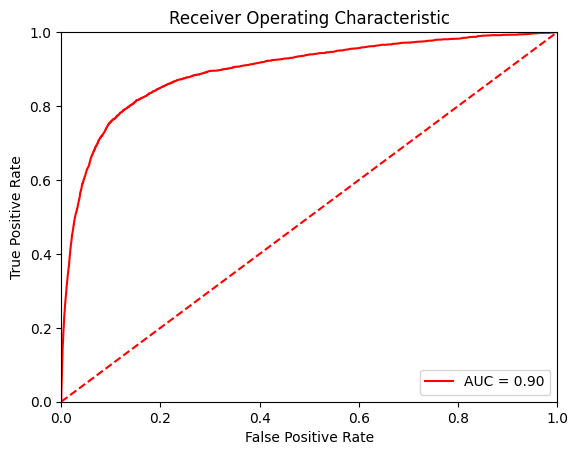

In [7]:
import matplotlib.pyplot as plt

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'r', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


In [16]:
print(thresholds[62])
print(tpr[62])
print(fpr[62])

0.9501953
0.05319822672577581
0.0007059182661121074


save the predictions for the test set and do some further analysis locally ...

In [67]:
TEST_PATH = '/home/skrhakv/cryptic-nn/data/cryptobench/test.txt'

def predict(sequence):
    sequence = 'MDLTNKNVIFVAALGGIGLDTSRELVKRNLKNFVILDRVENPTALAELKAINPKVNITFHTYDVTVPVAESKKLLKKIFDQLKTVDILINGAGILDDHQIERTIAINFTGLVNTTTAILDFWDKRKGGPGGIIANICSVTGFNAIHQVPVYSASKAAVVSFTNSLAKLAPITGVTAYSINPGITRTPLVHTFNSWLDVEPRVAELLLSHPTQTSEQCGQNFVKAIEANKNGAIWKLDLGTLEAIEWTKHWDSHI'
    tokenized_sequences = tokenizer(sequence, max_length=MAX_LENGTH, padding='max_length', truncation=True)
    # convert to tensor
    tokenized_sequences = {k: torch.tensor([v]).to(DEVICE) for k,v in tokenized_sequences.items()}
    output, _, _ = model(tokenized_sequences)
    output = output.flatten()

    mask = (tokenized_sequences['attention_mask'] == 1).flatten()

    output = torch.sigmoid(output[mask][1:-1]).detach().cpu().numpy()
    return output

with open(TEST_PATH) as f:
    reader = csv.reader(f, delimiter=";")

    for row in reader:
        sequence = row[4]
        # max sequence length of ESM2
        if len(sequence) > MAX_LENGTH: continue 

        indices = [int(residue[1:]) for residue in row[3].split(' ')]
        label = np.zeros(len(sequence)) #, dtype=np.float16)
        label[indices] = 1
        prediction = predict(sequence)

        assert len(sequence) == len(label)

        id = row[0] + row[1]
        np.save(f'/home/skrhakv/cryptic-nn/src/fine-tuning/predictions/predictions/{id}.npy', prediction)
        np.save(f'/home/skrhakv/cryptic-nn/src/fine-tuning/predictions/ground-truth/{id}.npy', label)
        
